<a href="https://colab.research.google.com/github/kanikachitnis1018/Summarizer/blob/main/flowchart_converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install torch

In [2]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import re


In [18]:
text_to_be_split = """ The factory receives fresh ingredients from suppliers, including grains, vegetables, fruits, and dairy products. Each shipment undergoes quality inspection to ensure safety and compliance with standards. Proper storage conditions are maintained to prevent spoilage before processing.

Raw materials are washed, chopped, and prepared for production. Machines handle mixing, cooking, and packaging. Automation helps maintain consistency in product quality and speed. Safety protocols are strictly followed to ensure hygiene during processing.

Every batch undergoes quality testing, including microbial tests, chemical analysis, and taste tests. Products that fail any test are discarded or reprocessed. Data from testing is recorded to track patterns and improve processes in the future.

Finished products are labeled and packed for shipping. Logistics teams manage distribution to retailers, supermarkets, and restaurants. Real-time tracking ensures timely delivery. Feedback from customers is used to optimize production and inventory management.
"""


paragraphs = text_to_be_split.split("\n\n")

paragraphs

[' The factory receives fresh ingredients from suppliers, including grains, vegetables, fruits, and dairy products. Each shipment undergoes quality inspection to ensure safety and compliance with standards. Proper storage conditions are maintained to prevent spoilage before processing.',
 'Raw materials are washed, chopped, and prepared for production. Machines handle mixing, cooking, and packaging. Automation helps maintain consistency in product quality and speed. Safety protocols are strictly followed to ensure hygiene during processing.',
 'Every batch undergoes quality testing, including microbial tests, chemical analysis, and taste tests. Products that fail any test are discarded or reprocessed. Data from testing is recorded to track patterns and improve processes in the future.',
 'Finished products are labeled and packed for shipping. Logistics teams manage distribution to retailers, supermarkets, and restaurants. Real-time tracking ensures timely delivery. Feedback from custom

In [19]:
cleaned_paras = []

for para in paragraphs:
    para = para.strip()

    para = re.sub(r'\s+', ' ', para)

    para = re.sub(r'[^a-zA-Z0-9.,;:!?()\'" -]', '', para)

    cleaned_paras.append(para)

for i, para in enumerate(cleaned_paras, 1):
    print(f"Paragraph {i}: {para}\n")

Paragraph 1: The factory receives fresh ingredients from suppliers, including grains, vegetables, fruits, and dairy products. Each shipment undergoes quality inspection to ensure safety and compliance with standards. Proper storage conditions are maintained to prevent spoilage before processing.

Paragraph 2: Raw materials are washed, chopped, and prepared for production. Machines handle mixing, cooking, and packaging. Automation helps maintain consistency in product quality and speed. Safety protocols are strictly followed to ensure hygiene during processing.

Paragraph 3: Every batch undergoes quality testing, including microbial tests, chemical analysis, and taste tests. Products that fail any test are discarded or reprocessed. Data from testing is recorded to track patterns and improve processes in the future.

Paragraph 4: Finished products are labeled and packed for shipping. Logistics teams manage distribution to retailers, supermarkets, and restaurants. Real-time tracking ensur

In [20]:
import nltk
from nltk.tokenize import sent_tokenize
from itertools import chain
from transformers import BertTokenizer, BertModel

nltk.download("punkt_tab")

sentences = list(chain.from_iterable(map(sent_tokenize, cleaned_paras)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [21]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

encoded = tokenizer(    # converts sentences to tokens
    sentences,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

with torch.no_grad():   # converts tokens to token embeddings
    outputs = model(**encoded)

embeddings = outputs.last_hidden_state    # converts token embeddings to sentence embeddings
sentence_embeddings = embeddings.mean(dim=1)

sentences_per_para = list(map(sent_tokenize, cleaned_paras))
para_lengths = list(map(len, sentences_per_para))

sentence_groups = torch.split(sentence_embeddings, para_lengths)


In [22]:
import torch.nn.functional as F
from operator import itemgetter

def summarize_all_paragraphs(sentence_groups, sentences_per_para, k=2):
    def summarize_one(group_sents):
        group, para_sents = group_sents
        if group.size(0) == 0:
            return ""

        para_embedding = group.mean(dim=0, keepdim=True)
        scores = F.cosine_similarity(group, para_embedding)
        k_safe = min(k, group.size(0))

        top_idx = scores.topk(k_safe).indices
        sorted_idx, _ = torch.sort(top_idx)

        selected = itemgetter(*sorted_idx.tolist())(para_sents)

        if isinstance(selected, tuple):
            return " ".join(selected)
        else:
            return selected

    return list(map(summarize_one, zip(sentence_groups, sentences_per_para)))


In [23]:
local_summaries = summarize_all_paragraphs(sentence_groups, sentences_per_para, k=4)

local_summaries

['The factory receives fresh ingredients from suppliers, including grains, vegetables, fruits, and dairy products. Each shipment undergoes quality inspection to ensure safety and compliance with standards. Proper storage conditions are maintained to prevent spoilage before processing.',
 'Raw materials are washed, chopped, and prepared for production. Machines handle mixing, cooking, and packaging. Automation helps maintain consistency in product quality and speed. Safety protocols are strictly followed to ensure hygiene during processing.',
 'Every batch undergoes quality testing, including microbial tests, chemical analysis, and taste tests. Products that fail any test are discarded or reprocessed. Data from testing is recorded to track patterns and improve processes in the future.',
 'Finished products are labeled and packed for shipping. Logistics teams manage distribution to retailers, supermarkets, and restaurants. Real-time tracking ensures timely delivery. Feedback from custome

In [24]:
from transformers import BartTokenizer, BartForConditionalGeneration

bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

inputs = bart_tokenizer(
    local_summaries,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=1024
)

summary_ids = bart_model.generate(
    inputs["input_ids"],
    num_beams=4,
    max_length=80,
    min_length=20,
    length_penalty=2.0,
    early_stopping=True
)

final_summaries = bart_tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

print(final_summaries)


['The factory receives fresh ingredients from suppliers, including grains, vegetables, fruits, and dairy products. Each shipment undergoes quality inspection to ensure safety and compliance with standards.', 'Raw materials are washed, chopped, and prepared for production. Machines handle mixing, cooking, and packaging. Automation helps maintain consistency in product quality and speed.', 'Every batch undergoes quality testing, including microbial tests, chemical analysis, and taste tests. Products that fail any test are discarded or reprocessed. Data from testing is recorded to track patterns and improve processes.', 'Finished products are labeled and packed for shipping. Logistics teams manage distribution to retailers, supermarkets and restaurants. Real-time tracking ensures timely delivery.']


In [25]:
!pip install yake

In [26]:
import yake

kw_extractor = yake.KeywordExtractor(lan="en", n=2, top=3)

keyword_tuples_per_para = list(map(kw_extractor.extract_keywords, final_summaries))

titles_per_para = list(map(lambda x: list(zip(*x))[0], keyword_tuples_per_para))

print(titles_per_para)


[('including grains', 'dairy products', 'factory receives'), ('Raw materials', 'chopped', 'Raw'), ('chemical analysis', 'including microbial', 'batch undergoes'), ('Finished products', 'Finished', 'shipping')]


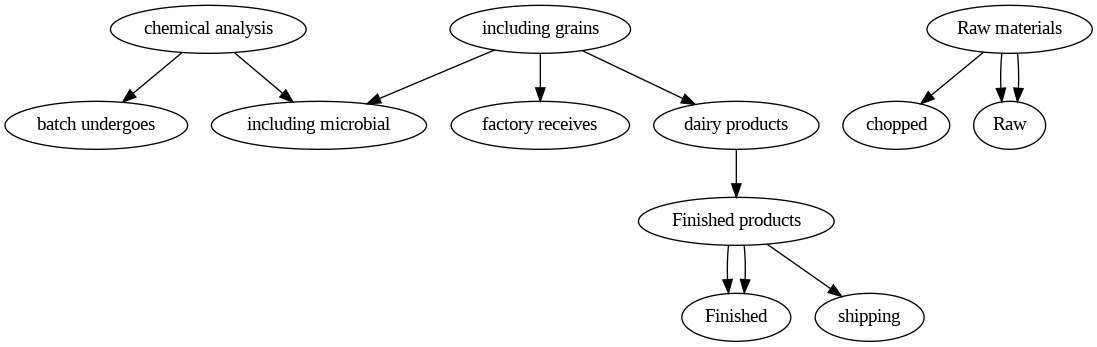

In [30]:
from graphviz import Digraph
from IPython.display import Image
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

dot = Digraph(comment="Conditional Flowchart")

all_nodes = list(set([kw for para in titles_per_para for kw in para]))
list(map(lambda n: dot.node(n, n), all_nodes))

list(map(lambda para: list(map(lambda kw: dot.edge(para[0], kw), para[1:])), titles_per_para))

all_keywords_flat = [kw for para in titles_per_para for kw in para]

vectorizer = TfidfVectorizer().fit(all_keywords_flat)
embeddings = vectorizer.transform(all_keywords_flat).toarray()

threshold = 0.3
pairs = list(combinations(range(len(all_keywords_flat)), 2))
list(map(lambda idx_pair: dot.edge(all_keywords_flat[idx_pair[0]], all_keywords_flat[idx_pair[1]])
         if cosine_similarity([embeddings[idx_pair[0]]], [embeddings[idx_pair[1]]])[0][0] > threshold else None, pairs))

dot.render("conditional_flowchart", format="png", cleanup=True)
Image("conditional_flowchart.png")
